## Contents
* Line of sight analysis

###### by Umesh

In [3]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
# import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = '../src' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from collections import defaultdict

In [5]:
from parameters import *

In [6]:
outdata_path = '../outdata/'

In [7]:
# List number of bouts for each animal
print('mouse  bouts')
to=0
max_bouts = 0
for nickname in AllNames:
    tf = LoadTrajFromPath(outdata_path + nickname+'-tf')
    print(nickname+'     ',len(tf.no))
    
    if len(tf.no) > max_bouts:
        max_bouts = len(tf.no)
        
    to+=len(tf.no)
print('Total  ',to)

mouse  bouts
B1      104
B2      166
B3      147
B4      238
C1      173
C3      339
C6      150
C7      135
C8      164
C9      127
B5      245
B6      223
B7      204
D3      245
D4      319
D5      180
D6      59
D7      150
D8      109
D9      102
Total   3579


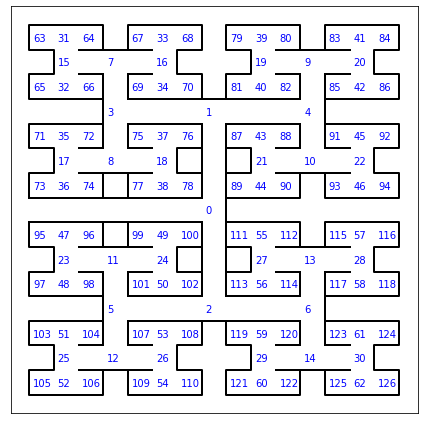

In [8]:
# Draw maze with node numbers
ma=NewMaze(6)
PlotMazeNodes(ma,figsize=6)

In [5]:
# define node numbers of all nodes
lv6_nodes = list(range(63,127))
lv5_nodes = list(range(31,63))
lv4_nodes = list(range(15,31))
lv3_nodes = list(range(7,15))
lv2_nodes = list(range(3,7))
lv1_nodes = list(range(1,3))
lv0_nodes = list(range(0,1))
lvl_dict = {0:lv0_nodes, 1:lv1_nodes, 2:lv2_nodes, 3:lv3_nodes, 4:lv4_nodes, 5:lv5_nodes, 6:lv6_nodes}

In [10]:
# inverse-define node numbers of all nodes mapped to depth
inv_lvl_dict = {n: level for level, nodes in lvl_dict.items() for n in nodes}
inv_lvl_dict[127] = -1   # home

#### Line of sight analysis

Out of 2 end nodes facing each other, the number of times one is visited **before** the other and analyze if the one being visited **first** while coming from a level 3->4 node is the one in line-of-sight.

In [11]:
left_nodes = dict.fromkeys(lv6_nodes[::2], 1)
right_nodes = dict.fromkeys(lv6_nodes[1::2], 1)

line_of_sight_left = np.array([63, 65, 71, 73, 95, 97, 103, 105, 79, 81, 87, 89, 111, 113, 119, 121])
line_of_sight_left_opp = line_of_sight_left + 1

line_of_sight_right = np.array([68, 70, 76, 78, 100, 102, 108, 110, 84, 86, 92, 94, 116, 118, 124, 126])
line_of_sight_right_opp = line_of_sight_right - 1

In [3]:
def level3_path(n):
    path = []
    path.append(n)
    levels = 3
    while levels:
        if n%2 == 0:
            n -= 1
        n = n//2
        levels -= 1
        path.append(n)
    return tuple(path)[::-1]

In [249]:
d = {}
for l in line_of_sight_left:
    print(l, level3_path(l)[-2])
    d[level3_path(l)[-2]] = l
for l in line_of_sight_right:
    print(l, level3_path(l)[-2])
    d[level3_path(l)[-2]] = l
print(d)

63 31
65 32
71 35
73 36
95 47
97 48
103 51
105 52
79 39
81 40
87 43
89 44
111 55
113 56
119 59
121 60
68 33
70 34
76 37
78 38
100 49
102 50
108 53
110 54
84 41
86 42
92 45
94 46
116 57
118 58
124 61
126 62
{31: 63, 32: 65, 35: 71, 36: 73, 47: 95, 48: 97, 51: 103, 52: 105, 39: 79, 40: 81, 43: 87, 44: 89, 55: 111, 56: 113, 59: 119, 60: 121, 33: 68, 34: 70, 37: 76, 38: 78, 49: 100, 50: 102, 53: 108, 54: 110, 41: 84, 42: 86, 45: 92, 46: 94, 57: 116, 58: 118, 61: 124, 62: 126}


In [250]:
level3_path(31), level3_path(70)

((3, 7, 15, 31), (7, 16, 34, 70))

In [15]:
def level5opp_path(n):
    path = []
    path.append(n)
    levels = 2
    while levels:
        if n%2 == 0:
            n -= 1
        n = n//2
        levels -= 1
        path.append(n)
    return tuple(path + [path[1]+1 if path[1]%2 else path[1]-1])[::-1]

In [16]:
level5opp_path(65), level5opp_path(66)

((31, 15, 32, 65), (31, 15, 32, 66))

In [17]:
level5opp_path(67), level5opp_path(68)

((34, 16, 33, 67), (34, 16, 33, 68))

In [1]:
def get_all_querypaths(func_path):
    valid_query_paths = {}
    for n in lv6_nodes:
        p = func_path(n)
        if p in valid_query_paths:
            raise Exception(f'duplicate path for node {n} from func {func_path}')
        valid_query_paths[p] = 1
    return valid_query_paths

In [7]:
level3_query_paths = get_all_querypaths(level3_path)
# level5opp_end_query_paths = get_all_querypaths(level5opp_path)

In [8]:
level3_query_paths

{(7, 15, 31, 63): 1,
 (7, 15, 31, 64): 1,
 (7, 15, 32, 65): 1,
 (7, 15, 32, 66): 1,
 (7, 16, 33, 67): 1,
 (7, 16, 33, 68): 1,
 (7, 16, 34, 69): 1,
 (7, 16, 34, 70): 1,
 (8, 17, 35, 71): 1,
 (8, 17, 35, 72): 1,
 (8, 17, 36, 73): 1,
 (8, 17, 36, 74): 1,
 (8, 18, 37, 75): 1,
 (8, 18, 37, 76): 1,
 (8, 18, 38, 77): 1,
 (8, 18, 38, 78): 1,
 (9, 19, 39, 79): 1,
 (9, 19, 39, 80): 1,
 (9, 19, 40, 81): 1,
 (9, 19, 40, 82): 1,
 (9, 20, 41, 83): 1,
 (9, 20, 41, 84): 1,
 (9, 20, 42, 85): 1,
 (9, 20, 42, 86): 1,
 (10, 21, 43, 87): 1,
 (10, 21, 43, 88): 1,
 (10, 21, 44, 89): 1,
 (10, 21, 44, 90): 1,
 (10, 22, 45, 91): 1,
 (10, 22, 45, 92): 1,
 (10, 22, 46, 93): 1,
 (10, 22, 46, 94): 1,
 (11, 23, 47, 95): 1,
 (11, 23, 47, 96): 1,
 (11, 23, 48, 97): 1,
 (11, 23, 48, 98): 1,
 (11, 24, 49, 99): 1,
 (11, 24, 49, 100): 1,
 (11, 24, 50, 101): 1,
 (11, 24, 50, 102): 1,
 (12, 25, 51, 103): 1,
 (12, 25, 51, 104): 1,
 (12, 25, 52, 105): 1,
 (12, 25, 52, 106): 1,
 (12, 26, 53, 107): 1,
 (12, 26, 53, 108): 1,
 (1

In [141]:
level5opp_end_query_paths

{(32, 15, 31, 63): 1,
 (32, 15, 31, 64): 1,
 (31, 15, 32, 65): 1,
 (31, 15, 32, 66): 1,
 (34, 16, 33, 67): 1,
 (34, 16, 33, 68): 1,
 (33, 16, 34, 69): 1,
 (33, 16, 34, 70): 1,
 (36, 17, 35, 71): 1,
 (36, 17, 35, 72): 1,
 (35, 17, 36, 73): 1,
 (35, 17, 36, 74): 1,
 (38, 18, 37, 75): 1,
 (38, 18, 37, 76): 1,
 (37, 18, 38, 77): 1,
 (37, 18, 38, 78): 1,
 (40, 19, 39, 79): 1,
 (40, 19, 39, 80): 1,
 (39, 19, 40, 81): 1,
 (39, 19, 40, 82): 1,
 (42, 20, 41, 83): 1,
 (42, 20, 41, 84): 1,
 (41, 20, 42, 85): 1,
 (41, 20, 42, 86): 1,
 (44, 21, 43, 87): 1,
 (44, 21, 43, 88): 1,
 (43, 21, 44, 89): 1,
 (43, 21, 44, 90): 1,
 (46, 22, 45, 91): 1,
 (46, 22, 45, 92): 1,
 (45, 22, 46, 93): 1,
 (45, 22, 46, 94): 1,
 (48, 23, 47, 95): 1,
 (48, 23, 47, 96): 1,
 (47, 23, 48, 97): 1,
 (47, 23, 48, 98): 1,
 (50, 24, 49, 99): 1,
 (50, 24, 49, 100): 1,
 (49, 24, 50, 101): 1,
 (49, 24, 50, 102): 1,
 (52, 25, 51, 103): 1,
 (52, 25, 51, 104): 1,
 (51, 25, 52, 105): 1,
 (51, 25, 52, 106): 1,
 (54, 26, 53, 107): 1,
 (

In [96]:
def _count_query_paths(nickname, valid_query_paths):
    first_visit_endnode_counts = dict.fromkeys(lv6_nodes, 0)
    tf = LoadTrajFromPath(outdata_path + nickname+'-tf')
    for i, bout in enumerate(tf.no):
        path = [node for node, _ in bout]
        for j in range(len(path)):
            query_path = tuple(path[j:j+4])
            if len(query_path) < 4:
                break
            if valid_query_paths.get(query_path, None) is not None:
                first_visit_endnode_counts[query_path[-1]] += 1
    return first_visit_endnode_counts

In [146]:
def get_left_points(counts, min_visits):
    lpoints = []
    for l, r in zip(line_of_sight_left, line_of_sight_left_opp):
        l_, r_ = counts[l], counts[r]
        if l_+r_ >= min_visits:
            node, percent  = l, (l_*100)/(l_+r_)
        else:
            node, percent = l, 0
        lpoints.append((node, percent))
    return lpoints

In [147]:
def get_right_points(counts, min_visits):
    rpoints = []
    for r, l in zip(line_of_sight_right, line_of_sight_right_opp):
        r_, l_ = counts[r], counts[l]
        if r_+l_ >= min_visits:
            node, percent = r, (r_*100)/(r_+l_)
        else:
            node, percent = r, 0
        rpoints.append((node, percent))
    return rpoints

In [148]:
def get_points(counts, min_visits):
    points = []
    for i, j in zip(range(63, 127, 2), range(64, 127, 2)):
        i_, j_ = counts[i], counts[j]
        if i_ + j_ >= min_visits:
            nodei, nodej, percenti, percentj = i, j, (i_*100)/(i_ + j_), (j_*100)/(i_ + j_)
        else:
            nodei, nodej, percenti, percentj = i, j, 0, 0
        points.append((nodei, nodej, percenti, percentj))
    return points

In [229]:
UnrewNamesSub

['B5', 'B6', 'B7', 'D3', 'D4', 'D5', 'D7', 'D8', 'D9']

In [234]:
def plot_los_preferences():
    los_preference_avg_level3 = defaultdict(int)
    los_preference_std_level3 = defaultdict(int)
    los_preference_avg_level5opp = defaultdict(int)
    los_preference_std_level5opp = defaultdict(int)
    
    min_visits = 6
#     los_preference_node_wise_dict = {}
    for nickname in RewNames+UnrewNamesSub:
    
        first_visit_level3_counts = _count_query_paths(nickname, level3_query_paths)
#         print(first_visit_level3_counts[119], first_visit_level3_counts[120])

        fig, axes = plt.subplots(1, 2, figsize=(15,5))

        # los path
        los_left_points = np.array(get_left_points(first_visit_level3_counts, min_visits))
        los_right_points = np.array(get_right_points(first_visit_level3_counts, min_visits))
#         print(los_left_points)
#         print(los_right_points)
        left_filtered = los_left_points[los_left_points[:, 1] > 0.0]
        right_filtered = los_right_points[los_right_points[:, 1] > 0.0]
#         print(left_filtered)
#         print(right_filtered)

        axes[0].plot(los_left_points[:, 0], los_left_points[:, 1], 'b*', label = 'left')
        axes[0].plot(los_right_points[:, 0], los_right_points[:, 1], 'b*', label = 'right')
        axes[0].set_title(f"coming from Level 3")
        axes[0].set_ylabel('% preference')
        axes[0].set_xlabel('end node number')
        axes[0].set_ylim([0, 100])
        los_preference_avg_level3[nickname] = np.mean(np.concatenate([left_filtered[:, 1], right_filtered[:, 1]]))
        los_preference_std_level3[nickname] = np.std(np.concatenate([left_filtered[:, 1], right_filtered[:, 1]]))
#         los_preference_node_wise_dict[nickname] = dict([(n, c) for n, p, c in los_left_points] + [(n, c) for n, p, c in los_right_points])

        # opp end path
        first_visit_level5opp_counts = _count_query_paths(nickname, level5opp_end_query_paths)
        points = np.array(get_points(first_visit_level5opp_counts, min_visits))
        axes[1].bar(points[:, 0], points[:, 3])
#         axes[1].bar(points[:, 1], points[:, 3])
        axes[1].set_title(f"coming from Level 5 (opp end)")
        axes[1].set_ylabel('% preference')
        axes[1].set_xlabel('end node number')
        axes[1].set_ylim([0, 100])
#         print(points)
        points_filtered = points[points[:, 3] > 0.0]
#         print(points_filtered)
        los_preference_avg_level5opp[nickname] = np.mean(points_filtered[:, 3]) # any one of the nodes among 2
        los_preference_std_level5opp[nickname] = np.std(points_filtered[:, 3])
        plt.suptitle(f"Mouse {nickname}")

#         plt.show()
    return los_preference_avg_level3, los_preference_std_level3, los_preference_avg_level5opp, los_preference_std_level5opp


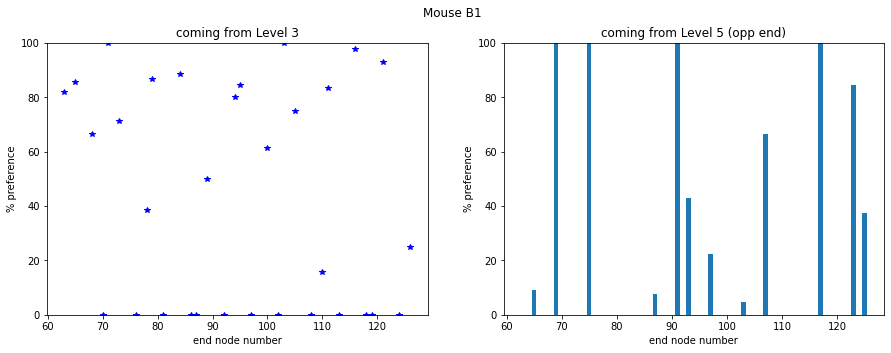

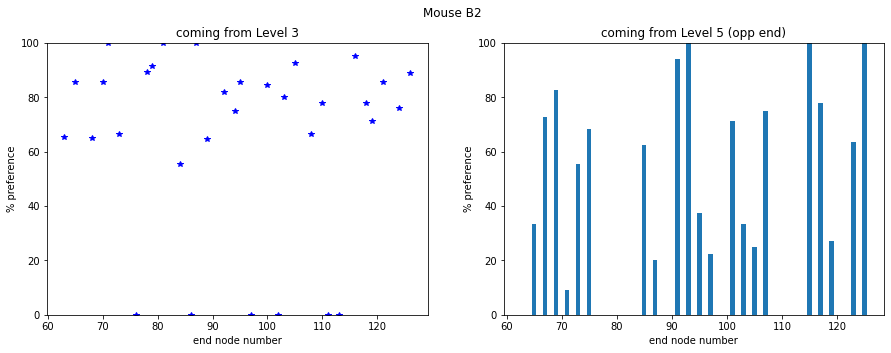

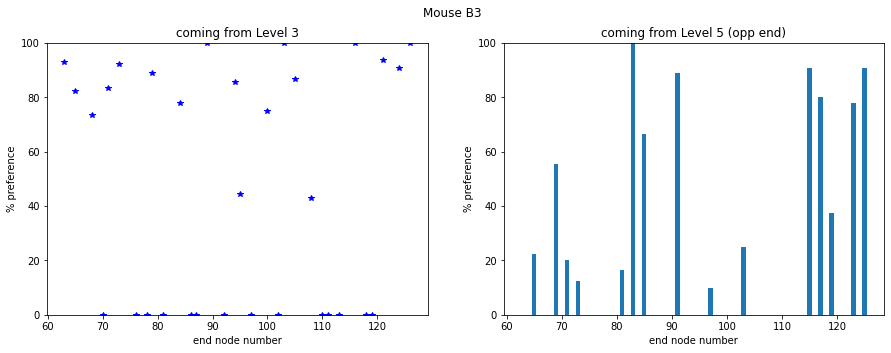

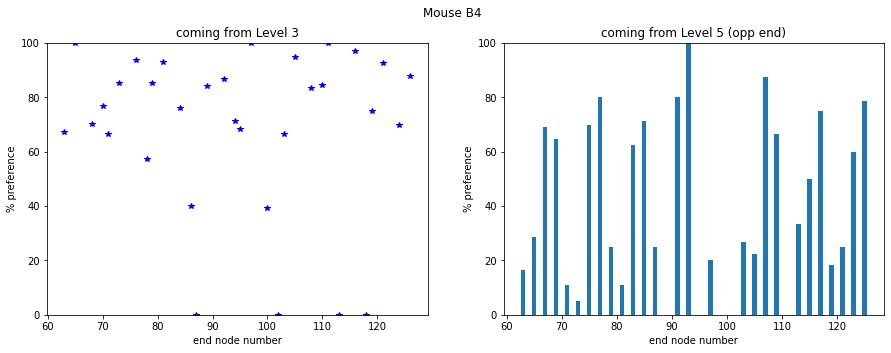

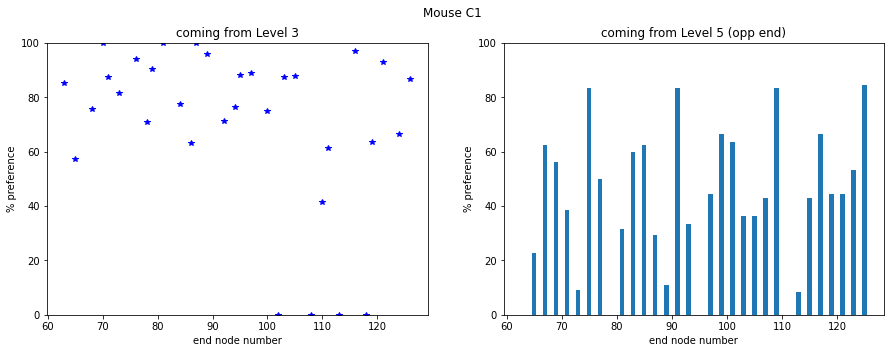

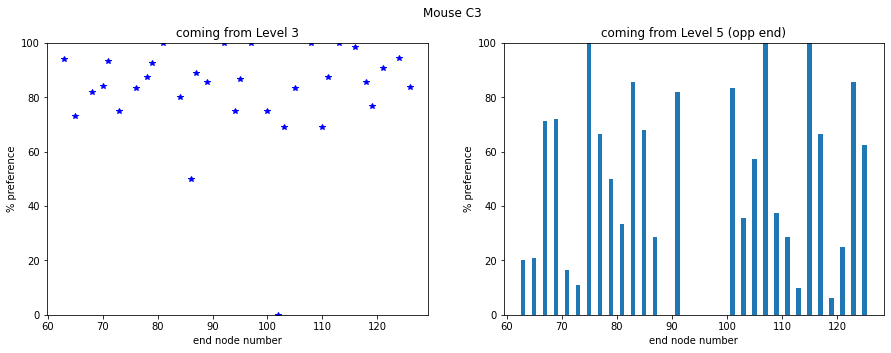

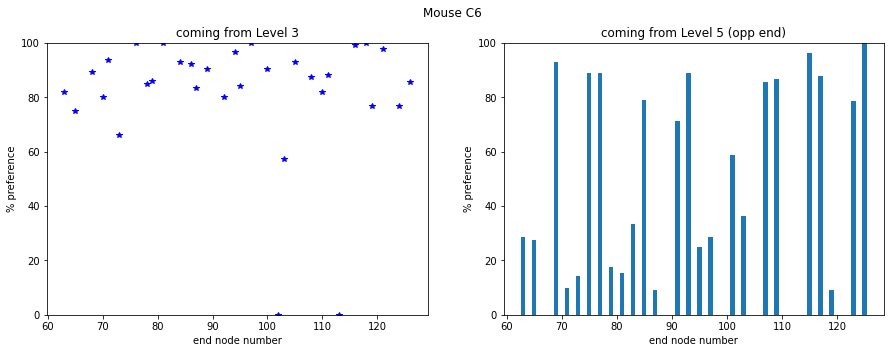

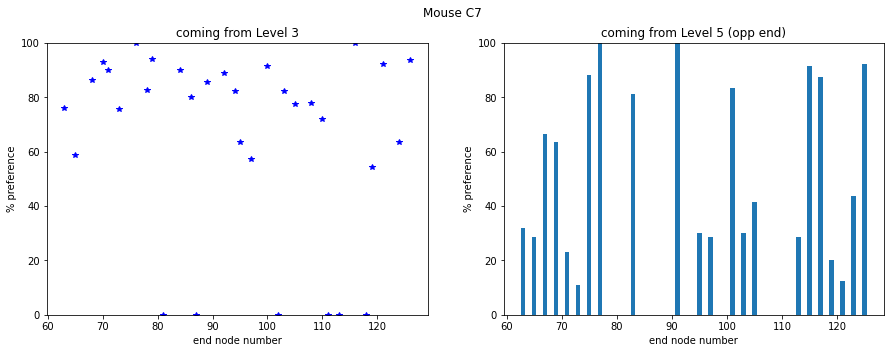

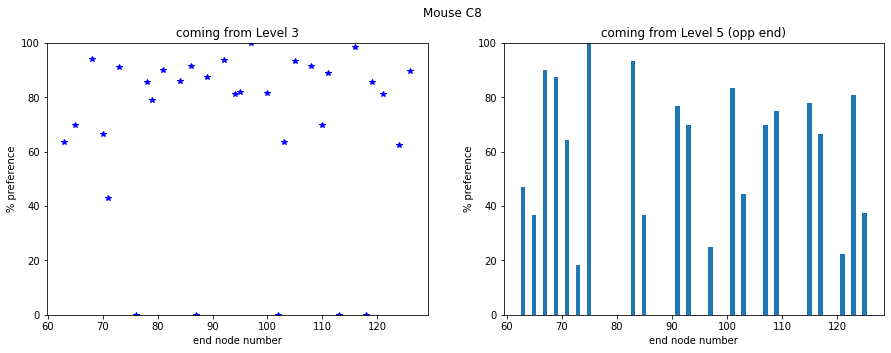

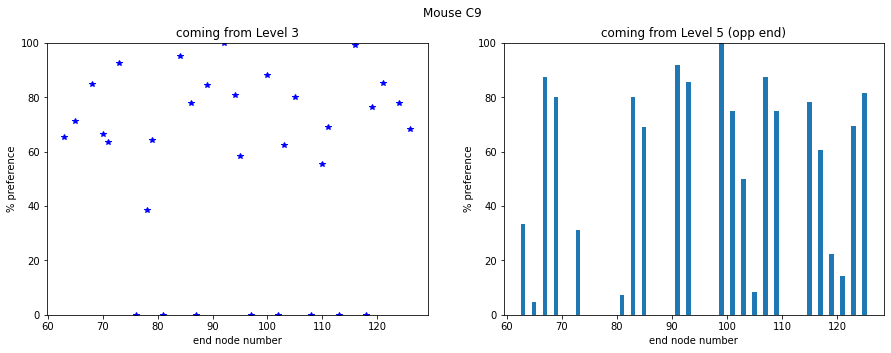

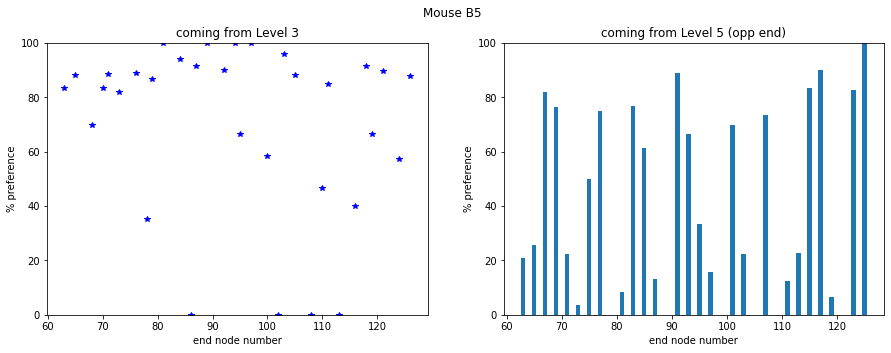

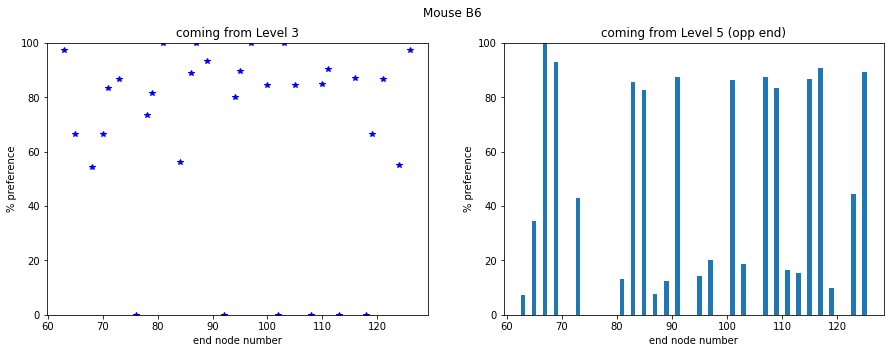

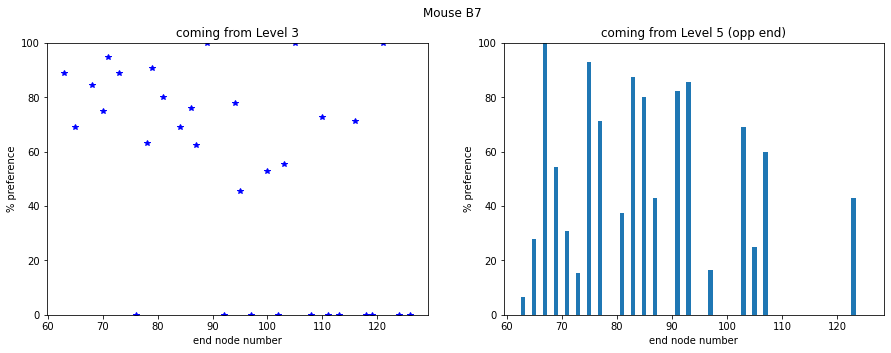

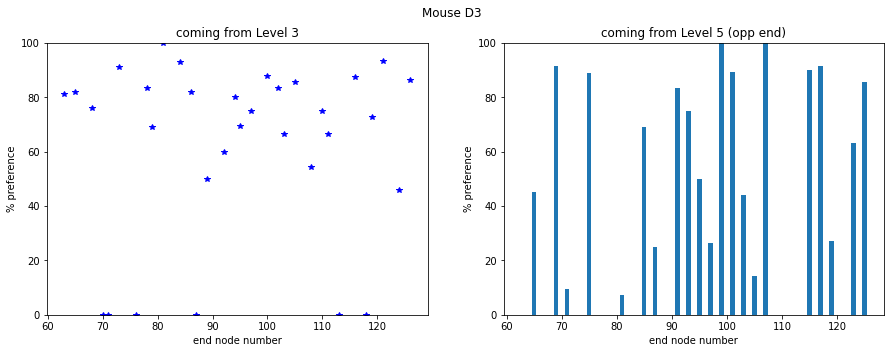

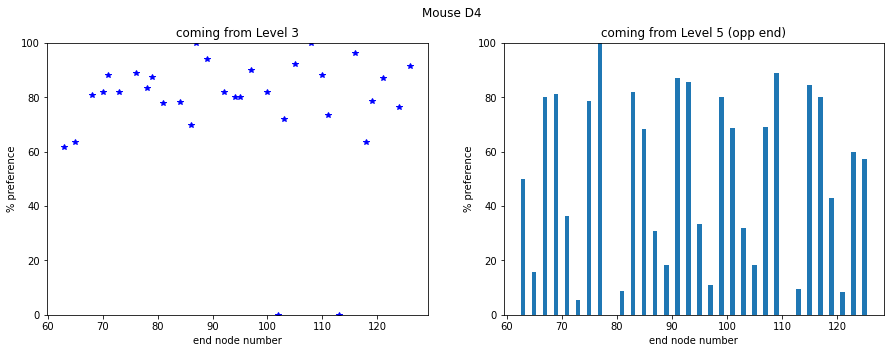

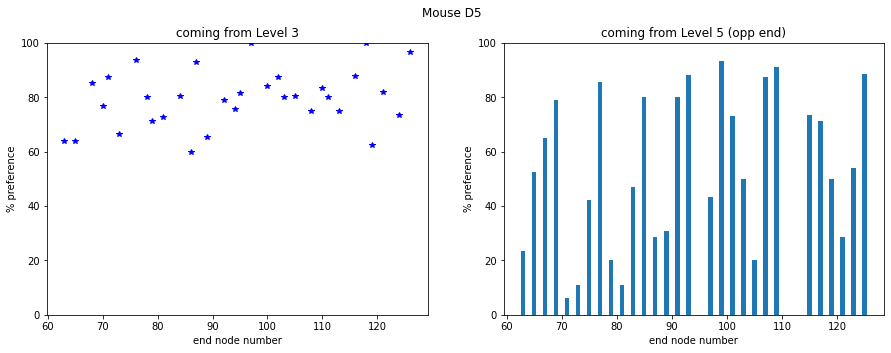

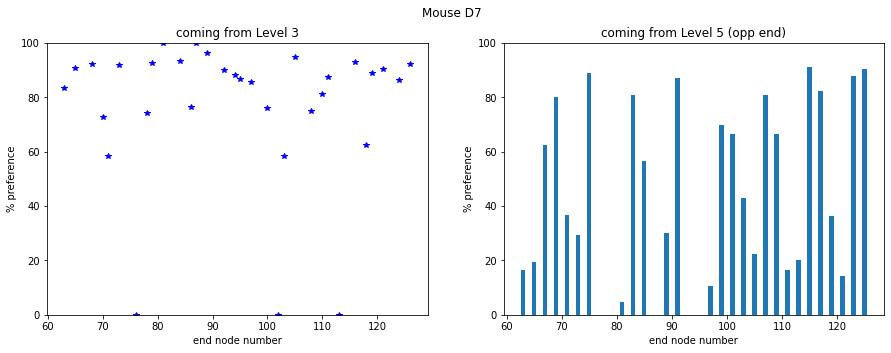

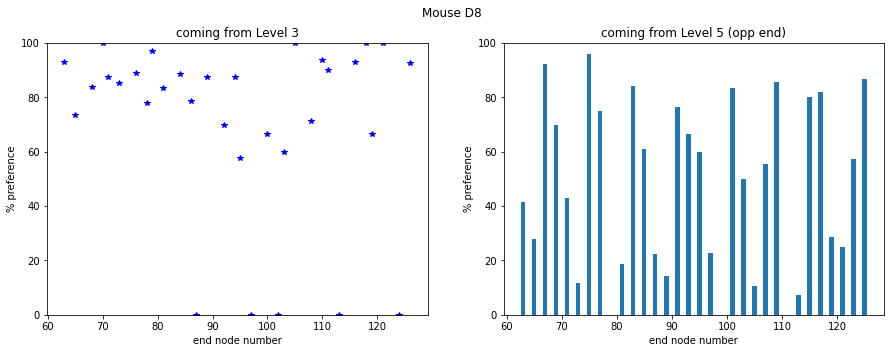

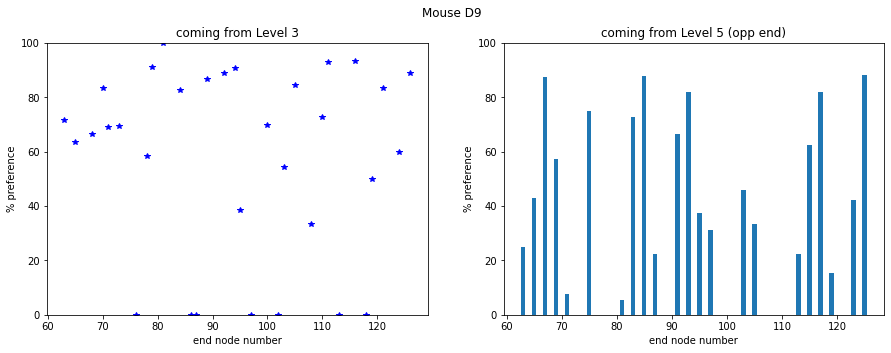

In [235]:
los_preference_avg_level3, los_preference_std_level3, los_preference_avg_level5opp, los_preference_std_level5opp = plot_los_preferences()



In [236]:
los_preference_avg_level3

defaultdict(int,
            {'B1': 72.90489325603616,
             'B2': 81.12469115565091,
             'B3': 83.89959668145943,
             'B4': 79.03950963788637,
             'C1': 80.88676123820412,
             'C3': 85.33601778013735,
             'C6': 87.07902186437163,
             'C7': 81.15685587375184,
             'C8': 81.89694437218124,
             'C9': 75.29390325997018,
             'B5': 80.57549779818689,
             'B6': 82.9049941292034,
             'B7': 77.09374534387116,
             'D3': 76.84813973651765,
             'D4': 82.38769822785373,
             'D5': 79.53120253963135,
             'D7': 84.81278274130021,
             'D8': 84.20615132634578,
             'D9': 73.8048310424187})

In [237]:
los_preference_std_level3

defaultdict(int,
            {'B1': 23.953999700686982,
             'B2': 12.032867518440986,
             'B3': 16.401324773957526,
             'B4': 16.002374166804227,
             'C1': 14.48189546404982,
             'C3': 11.263487369112406,
             'C6': 10.125771274215639,
             'C7': 12.793546963259962,
             'C8': 13.126912350099815,
             'C9': 14.627594690115481,
             'B5': 18.043473055679627,
             'B6': 13.965175615354603,
             'B7': 15.522167215068293,
             'D3': 13.372610073154313,
             'D4': 9.855722440397232,
             'D5': 10.4799470457184,
             'D7': 11.158462640823844,
             'D8': 12.243499092789456,
             'D9': 17.323165089167155})

In [238]:
los_preference_avg_level5opp

defaultdict(int,
            {'B1': 56.26584064084065,
             'B2': 58.644069605744896,
             'B3': 52.973063973063965,
             'B4': 47.545336532264635,
             'C1': 48.28541131518242,
             'C3': 52.77696134275082,
             'C6': 54.36983687178626,
             'C7': 53.82878114161537,
             'C8': 62.088752484595034,
             'C9': 58.77261646730408,
             'B5': 49.38870941675699,
             'B6': 51.28120529861682,
             'B7': 54.17040036307082,
             'D3': 60.79395653079864,
             'D4': 52.38559087866222,
             'D5': 54.34823021351932,
             'D7': 51.56542342746823,
             'D8': 52.93269044471114,
             'D9': 49.662130872692366})

In [239]:
los_preference_std_level5opp

defaultdict(int,
            {'B1': 38.20270400435975,
             'B2': 28.638789508237902,
             'B3': 32.43180480040426,
             'B4': 27.857772577490028,
             'C1': 21.596869685286237,
             'C3': 29.853407467956647,
             'C6': 33.344691434594914,
             'C7': 30.735835802474995,
             'C8': 24.62928499123489,
             'C9': 30.650462578558034,
             'B5': 31.54347240636168,
             'B6': 35.48792114846539,
             'B7': 28.573774496837565,
             'D3': 31.44507822691064,
             'D4': 30.224691533616838,
             'D5': 27.509852941865745,
             'D7': 29.562559129833595,
             'D8': 28.221198243755055,
             'D9': 26.972944683593816})

In [1]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
xlen = len(RewNames+UnrewNamesSub)
axes[0].errorbar(range(xlen), los_preference_avg_level3.values(), yerr=los_preference_std_level3.values(), fmt='c*')
axes[0].set_xticks(np.arange(xlen))
axes[0].set_xticklabels(RewNames+UnrewNamesSub)
axes[0].set_xlabel('Mouse')
axes[0].set_ylabel('%age preference')
axes[0].set_title('Coming from level 3')
axes[0].set_ylim([0,100])

axes[1].errorbar(range(xlen),los_preference_avg_level5opp.values(), yerr=los_preference_std_level5opp.values(), fmt='c*')
axes[1].set_xticks(np.arange(xlen))
axes[1].set_xticklabels(RewNames+UnrewNamesSub)
axes[1].set_xlabel('Mouse')
axes[1].set_ylabel('%age preference')
axes[1].set_title('Coming from level 5 (opposite end)')
axes[1].set_ylim([0,100])

axes[0].plot([80]*xlen, 'r-', label='y=80')
axes[1].plot([50]*xlen, 'r-', label='y=50')
axes[0].legend()
axes[1].legend()
plt.show()

NameError: name 'plt' is not defined

#### Check for global direction (corner or middle)

In [9]:
def get_nodes_in_a_box(n):
    '''using level 4 node i.e. box center'''
    return [4*n+3, 4*n+4, 4*n+5, 4*n+6]

In [26]:
corner_nodes = [15, 20, 25, 30]
ver_middle_nodes = [16, 19, 26, 29]
hor_middle_nodes = [17, 22, 23, 28]
central_nodes = [18, 21, 24, 27]
middle_nodes = ver_middle_nodes + hor_middle_nodes

In [10]:
def _count_node_visits_per_mouse(nickname):
    endnode_counts = defaultdict(int)
    tf = LoadTraj(nickname+'-tf')
    for i, bout in enumerate(tf.no):
        for node, _ in bout:
            endnode_counts[node] += 1
    total = sum([endnode_counts[i] for i in lv6_nodes]) + 1
    for i in endnode_counts:
        endnode_counts[i] = round(endnode_counts[i]/total, 4)
    return endnode_counts

In [11]:
endnode_visit_counts = {}
for nickname in AllNames:
    endnode_visit_counts[nickname] = _count_node_visits_per_mouse(nickname)

In [66]:
def get_global_direction(nodes, mouse_list, expand=True):
    global_direction = defaultdict(list)
    if expand:
        expand_nodes = [i for c in nodes for i in get_nodes_in_a_box(c)]
    else:
        expand_nodes = nodes
    print(nodes, " =>", expand_nodes)
    for nickname in mouse_list:
        global_direction[nickname] = sum([endnode_visit_counts[nickname][c] for c in expand_nodes])
    return global_direction

In [67]:
def plot_fraction_visits_by_level6(mouse_list):
    labels = []
    dir_data = []
    for c in corner_nodes:
        nodes = get_nodes_in_a_box(c)
        for node in nodes:
            avg_global_direction = get_global_direction([node], mouse_list, expand=False)
            dir_data.append(list(avg_global_direction.values()))
            labels.append(node)
#     print(dir_data)
    plt.boxplot(dir_data, labels=labels)
    plt.ylabel('fraction visits')
    plt.show()
    return

[63]  => [63]
[64]  => [64]
[65]  => [65]
[66]  => [66]
[83]  => [83]
[84]  => [84]
[85]  => [85]
[86]  => [86]
[103]  => [103]
[104]  => [104]
[105]  => [105]
[106]  => [106]
[123]  => [123]
[124]  => [124]
[125]  => [125]
[126]  => [126]


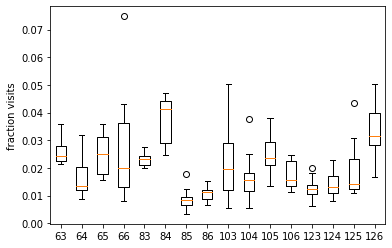

In [68]:
plot_fraction_visits_by_level6(RewNames)

In [13]:
def plot_fraction_visits_by_level4(mouse_list):
    labels = []
    dir_data = []
    for node in lv4_nodes:
        avg_global_direction = get_global_direction([node], mouse_list)
        dir_data.append(list(avg_global_direction.values()))
        labels.append(node)
#     print(dir_data)
    plt.boxplot(dir_data, labels=labels)
    plt.ylabel('fraction visits')
    plt.show()
    return

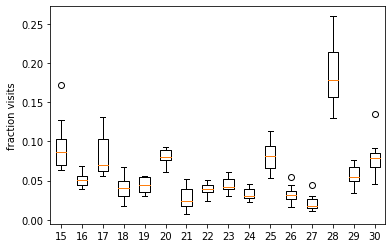

In [14]:
plot_fraction_visits_by_level4(RewNames)

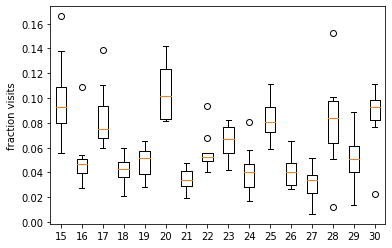

In [34]:
plot_fraction_visits_by_level4(UnrewNames) # except D6

* same trend?
* higher in 15 17 20 25 29 30?

In [27]:
reward_node = [28]
corner_nodes = [15, 20, 25, 30]
non_corner_nodes = list(set(lv4_nodes)-set(corner_nodes)-set(reward_node))
def plot_fraction_visits_by_corner(mouse_list):
    labels = []
    cor_dir_data = []
    noncor_dir_data = []
    for node in lv4_nodes:
        avg_global_direction = get_global_direction([node], mouse_list)
        if node in corner_nodes:
            cor_dir_data.append(list(avg_global_direction.values()))
        elif node in non_corner_nodes:
            noncor_dir_data.append(list(avg_global_direction.values()))
    labels = ['corner', 'non-corner']
    plt.boxplot([np.mean(cor_dir_data, axis=0), np.mean(noncor_dir_data, axis=0)], labels=labels)
    plt.ylabel('fraction visits')
    plt.show()
    return

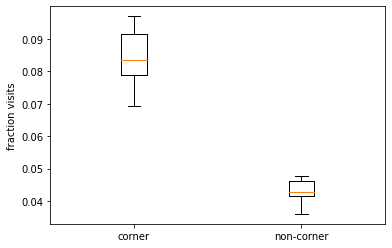

In [28]:
plot_fraction_visits_by_corner(RewNames)

corner vs non corner boxes (not including reward box)

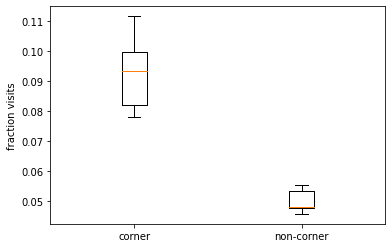

In [48]:
plot_fraction_visits_by_corner(UnrewNames)